In [1]:
#Snowflake
from sqlalchemy import create_engine, sql
from snowflake.sqlalchemy import URL

#Librairies
from os import environ
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
%matplotlib inline

/Users/alicegoulley/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (4.0.1), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
url = URL(
    account = environ.get('SNOWFLAKE_ACCOUNT'),
    user = environ.get('SNOWFLAKE_USER'),
    password = environ.get('SNOWFLAKE_PWD'),
    database = 'production',
    schema = 'common',
    warehouse = environ.get('SNOWFLAKE_WH'),
    role = environ.get('SNOWFLAKE_ROLE'),
)

In [3]:
qstr = '''
    
    select distinct
        rentals.id,
        car_id,
        precise_ends_at,
        checkin_mileage,
        checkout_mileage,
        lag(checkout_mileage) over (partition by car_id order by precise_ends_at) as previous_checkout_mileage,
        checkout_mileage - checkin_mileage as mileage_run

    from common.rentals 

    left join common.cars
        on rentals.car_id = cars.id 

    where rentals.state = 'ended'
    and is_open
    and cars.state = 'active'
    and checkin_type = 'open'


'''


In [4]:
engine_snowflake = create_engine(url)
connection = engine_snowflake.connect()
try:
    df = pd.read_sql(
        qstr, 
        engine_snowflake
        
    )
    # You can directly cast the date columns as dates by adding in 
    # pd.read_sql_query the arg parse_dates=['name_column_date1','name_column_date2']
finally:
    connection.close()
    engine_snowflake.dispose()

In [5]:
df.head()

,id,car_id,precise_ends_at,checkin_mileage,checkout_mileage,previous_checkout_mileage,mileage_run
0,6453901,927293,2021-12-30 17:00:00,106696.0,106741.0,106681.0,45.0
1,6766251,927293,2022-06-01 18:00:00,108734.0,108743.0,108734.0,9.0
2,6721535,926549,2022-05-14 17:30:00,52953.0,53004.0,52953.0,51.0
3,6792285,926549,2022-06-10 04:00:00,53876.0,53927.0,53876.0,51.0
4,6280299,847672,2021-10-27 20:30:00,81562.0,84440.0,81562.0,2878.0


<AxesSubplot:>

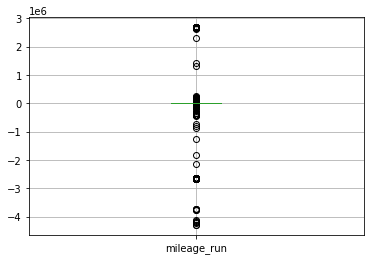

In [6]:
df.boxplot('mileage_run')

In [7]:
df = df[df['mileage_run']>0]

<AxesSubplot:>

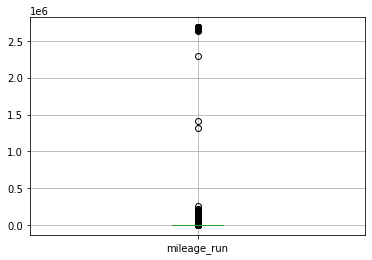

In [8]:
df.boxplot('mileage_run')

In [9]:
df['mileage_run'].describe()

count    4.603310e+05
mean     6.208524e+03
std      1.254749e+05
min      1.000000e+00
25%      6.300000e+01
50%      1.540000e+02
75%      3.510000e+02
max      2.684350e+06
Name: mileage_run, dtype: float64

In [16]:
Q1 = 6.300000e+01
Q3 = 3.510000e+02

In [17]:
IQR = Q3 - Q1

In [24]:
IQR

288.0

In [18]:
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR

In [22]:
lower_range

-369.0

In [23]:
upper_range

783.0

In [19]:
df2 = df.loc[((df['mileage_run']<upper_range)\
       & (df['mileage_run']>lower_range))
       | (df['mileage_run'].isna())]

In [20]:
df2['mileage_run'].describe()

count    426126.000000
mean        197.826305
std         180.094976
min           1.000000
25%          58.000000
50%         137.000000
75%         287.000000
max         782.000000
Name: mileage_run, dtype: float64

<AxesSubplot:>

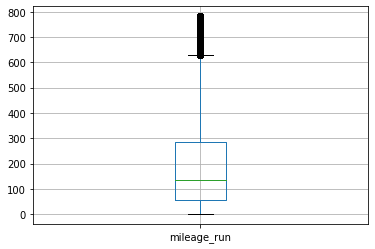

In [21]:
df2.boxplot('mileage_run')